<a href="https://colab.research.google.com/github/kjprice/smu-capstone/blob/master/notebooks/ASL_Signs_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os, shutil, copy, ntpath, datetime, zipfile
import keras
from keras import models, layers, callbacks
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


## Make sure we have GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Settings

In [0]:
IMAGE_SHAPE=(150, 150, 3)

#LIMIT_BATCHES = 593
LIMIT_BATCHES = None

NUM_EPOCHS = 10
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = 'conv_base_vgg16'
# PRETRAIN_MODEL = None

USE_PREPROCESSED_IMAGES = False

TEST_TRAIN_SPLIT = .95 # Train Size

#### Set Folders

In [0]:
#### FilePath Information
DATA_DIR = '/content/gdrive/My Drive/SMU/Capstone/DataSets/'

LOCAL_DATASET_DIR = '/tmp/asl_alphabet'

SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

In [0]:
if USE_PREPROCESSED_IMAGES:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet.zip')
  local_dataset_zip = '/tmp/asl_alphabet.zip'
  train_dataset_name = 'processed_asl_train'
  temp_unzip_directory = '/tmp/data/fabricated/asl_alphabet'
else:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet_original.zip')
  local_dataset_zip = '/tmp/asl_alphabet_original.zip'
  train_dataset_name = 'split_asl_alphabet_train'
  temp_unzip_directory = '/tmp/asl_alphabet_original/data/fabricated/asl_alphabet'
  
TRAIN_DATASET_NAME = train_dataset_name
ASL_ALPHABET_DATASET_ZIP = dataset_zip
LOCAL_DATASET_ZIP = local_dataset_zip
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)
TEMP_UNZIP_DIRECTORY = temp_unzip_directory

#### Download Data

In [0]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)


#### Extract Data

In [8]:
if os.path.isdir(LOCAL_DATASET_DIR):
  shutil.rmtree(LOCAL_DATASET_DIR)
with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
    %time zip_ref.extractall('/tmp')

CPU times: user 17.3 s, sys: 6.36 s, total: 23.7 s
Wall time: 24.2 s


In [0]:
if not os.path.isdir(TEMP_UNZIP_DIRECTORY):
  print('not sure where the zip folder exported the directory but it is not where we expected')
else:
  shutil.move(TEMP_UNZIP_DIRECTORY, LOCAL_DATASET_DIR)

In [10]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['split_asl_alphabet_train', 'split_asl_alphabet_test']


In [11]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 1 test sets


#### Create Split training/test data

In [0]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [0]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)

#### Create Data Generators

In [0]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [16]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 74385 images belonging to 29 classes.
Found 8265 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.


# Models

In [0]:
def create_vgg_model():
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(29, activation='sigmoid'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [0]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [19]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
elif PRETRAIN_MODEL == 'conv_base_vgg16':
    model = create_vgg_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [20]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(validation_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = (LIMIT_BATCHES / len(train_generator)) * len(validation_generator)
  steps_per_epoch_test = (LIMIT_BATCHES / len(train_generator)) * len(test_generators[0])

print('total batches {}'.format(len(train_generator)))
print('steps_per_epoch_train {}'.format(steps_per_epoch_train))
print('steps_per_epoch_test {}'.format(steps_per_epoch_test))
print('steps_per_epoch_val {}'.format(steps_per_epoch_val))


total batches 3720
steps_per_epoch_train 3720
steps_per_epoch_test 218
steps_per_epoch_val 414


In [21]:

history= model.fit_generator (
train_generator,
epochs = NUM_EPOCHS,
steps_per_epoch=steps_per_epoch_train,
validation_steps=steps_per_epoch_val,
#callbacks = callbacks_list,
validation_data=validation_generator,
verbose=1 \
)

Epoch 1/10
3720/3720 [==============================] - 732s 197ms/step - loss: 1.1144 - acc: 0.7076 - val_loss: 1.0038 - val_acc: 0.6881
Epoch 2/10
3720/3720 [==============================] - 725s 195ms/step - loss: 0.4841 - acc: 0.8580 - val_loss: 0.7950 - val_acc: 0.7572
Epoch 3/10
3720/3720 [==============================] - 726s 195ms/step - loss: 0.3649 - acc: 0.8905 - val_loss: 0.6363 - val_acc: 0.7966
Epoch 4/10
3720/3720 [==============================] - 725s 195ms/step - loss: 0.2988 - acc: 0.9076 - val_loss: 0.6094 - val_acc: 0.8088
Epoch 5/10
3720/3720 [==============================] - 724s 195ms/step - loss: 0.2613 - acc: 0.9187 - val_loss: 0.6365 - val_acc: 0.7984
Epoch 6/10
3720/3720 [==============================] - 719s 193ms/step - loss: 0.2367 - acc: 0.9244 - val_loss: 0.5983 - val_acc: 0.8162
Epoch 7/10
3720/3720 [==============================] - 722s 194ms/step - loss: 0.2206 - acc: 0.9301 - val_loss: 0.6302 - val_acc: 0.8137
Epoch 8/10
3720/3720 [============

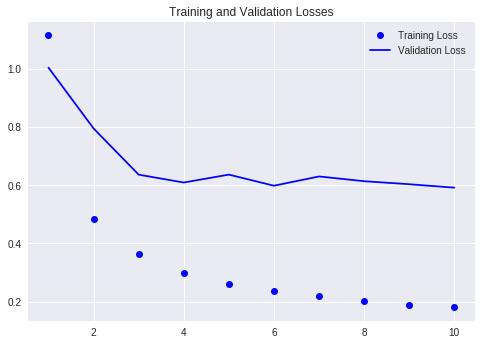

In [22]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

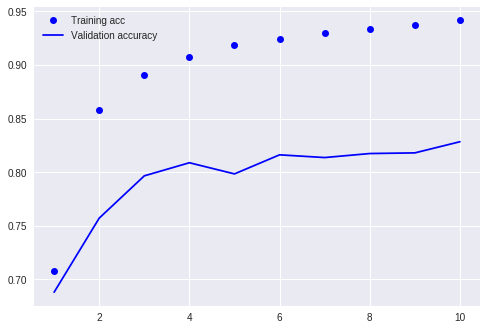

In [23]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [24]:
for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
  test_loss, test_acc = model.evaluate_generator(generator, steps=steps_per_epoch_test)
  print('{}: {}'.format(_dir, test_acc))

/tmp/asl_alphabet/split_asl_alphabet_test: 0.9662068909612195
